# Introduction

In this notebook, we explore the analysis and visualization of astronomical data obtained from FITS (Flexible Image Transport System) files. The primary goal is to process moment maps derived from various molecular line emissions within the galaxy NGC 0628. We apply a series of image processing techniques to handle corrupted pixels, reconstruct images, enhance their quality, and simulate super-resolution to improve spatial resolution.

---

# Code Overview

The code begins with the necessary library imports, including NumPy for numerical operations, Matplotlib for plotting, Astropy for handling FITS files, and various functions from SciPy and scikit-image for image processing. These libraries enable the manipulation of multidimensional arrays and provide a suite of tools for filtering, convolution, and visualization.

---

# Loading FITS Files

A list of FITS file paths is defined, each containing data pertaining to the molecular emissions from NGC 0628. These files will be processed to generate moment maps, which represent integrated intensity across specified velocity ranges. This processing is essential for analyzing the physical characteristics of the observed regions.

---

# Image Processing Functions

Several functions are defined to facilitate the image processing workflow:

1. **Creating Bad Pixels**: The `create_bad_pixels` function introduces random bad pixels into the image, simulating real-world data imperfections. This function generates both isolated bad pixels and cross-shaped regions, allowing for more comprehensive testing of the reconstruction methods.

2. **Image Reconstruction**: The `reconstruct_image` function replaces NaN values in the image (representing bad pixels) with the mean of their neighboring pixels. While a simplistic approach, this method provides a foundation for more sophisticated reconstruction algorithms.

3. **Image Enhancement**: The `enhance_image` function applies Gaussian filtering to smooth the image and uses contrast stretching to enhance the overall appearance. This step is crucial for visual clarity and subsequent analysis.

4. **Cleaning Artifacts**: The `clean_artifacts` function employs median filtering and binary opening to remove small artifacts from the reconstructed images, ensuring that the resulting data is as clean and representative as possible.

5. **Simulating Super-Resolution**: The `simulate_super_resolution` function uses interpolation to upscale the image, providing a higher resolution representation of the moment maps. This technique is valuable for enhancing visual detail in the data.

---

# Processing the FITS Files

The main processing loop iterates through each FITS file. For each file, the data is loaded, and moment maps are calculated. The moment-0 map, representing the integrated intensity, is derived by summing the cube data across the specified axis. Each processed image is subjected to the previously defined functions, resulting in corrupted, reconstructed, and enhanced images.

---

# Visualization

The code concludes with a visualization section, where original, corrupted, reconstructed, enhanced, and simulated super-resolution images are plotted for comparison. Each subplot is labeled appropriately, and color bars are added to convey the intensity scale. This visual representation aids in assessing the effectiveness of the processing techniques and the quality of the reconstructed images.


Processing fits_GL/EMPIRE_ngc0628_13co_27as.fits
Processing fits_GL/EMPIRE_ngc0628_c18o_27as.fits
Processing fits_GL/EMPIRE_ngc0628_co_26as.fits
Processing fits_GL/EMPIRE_ngc0628_hcn_33as.fits
Processing fits_GL/EMPIRE_ngc0628_hcop_33as.fits
Processing fits_GL/EMPIRE_ngc0628_hnc_33as.fits


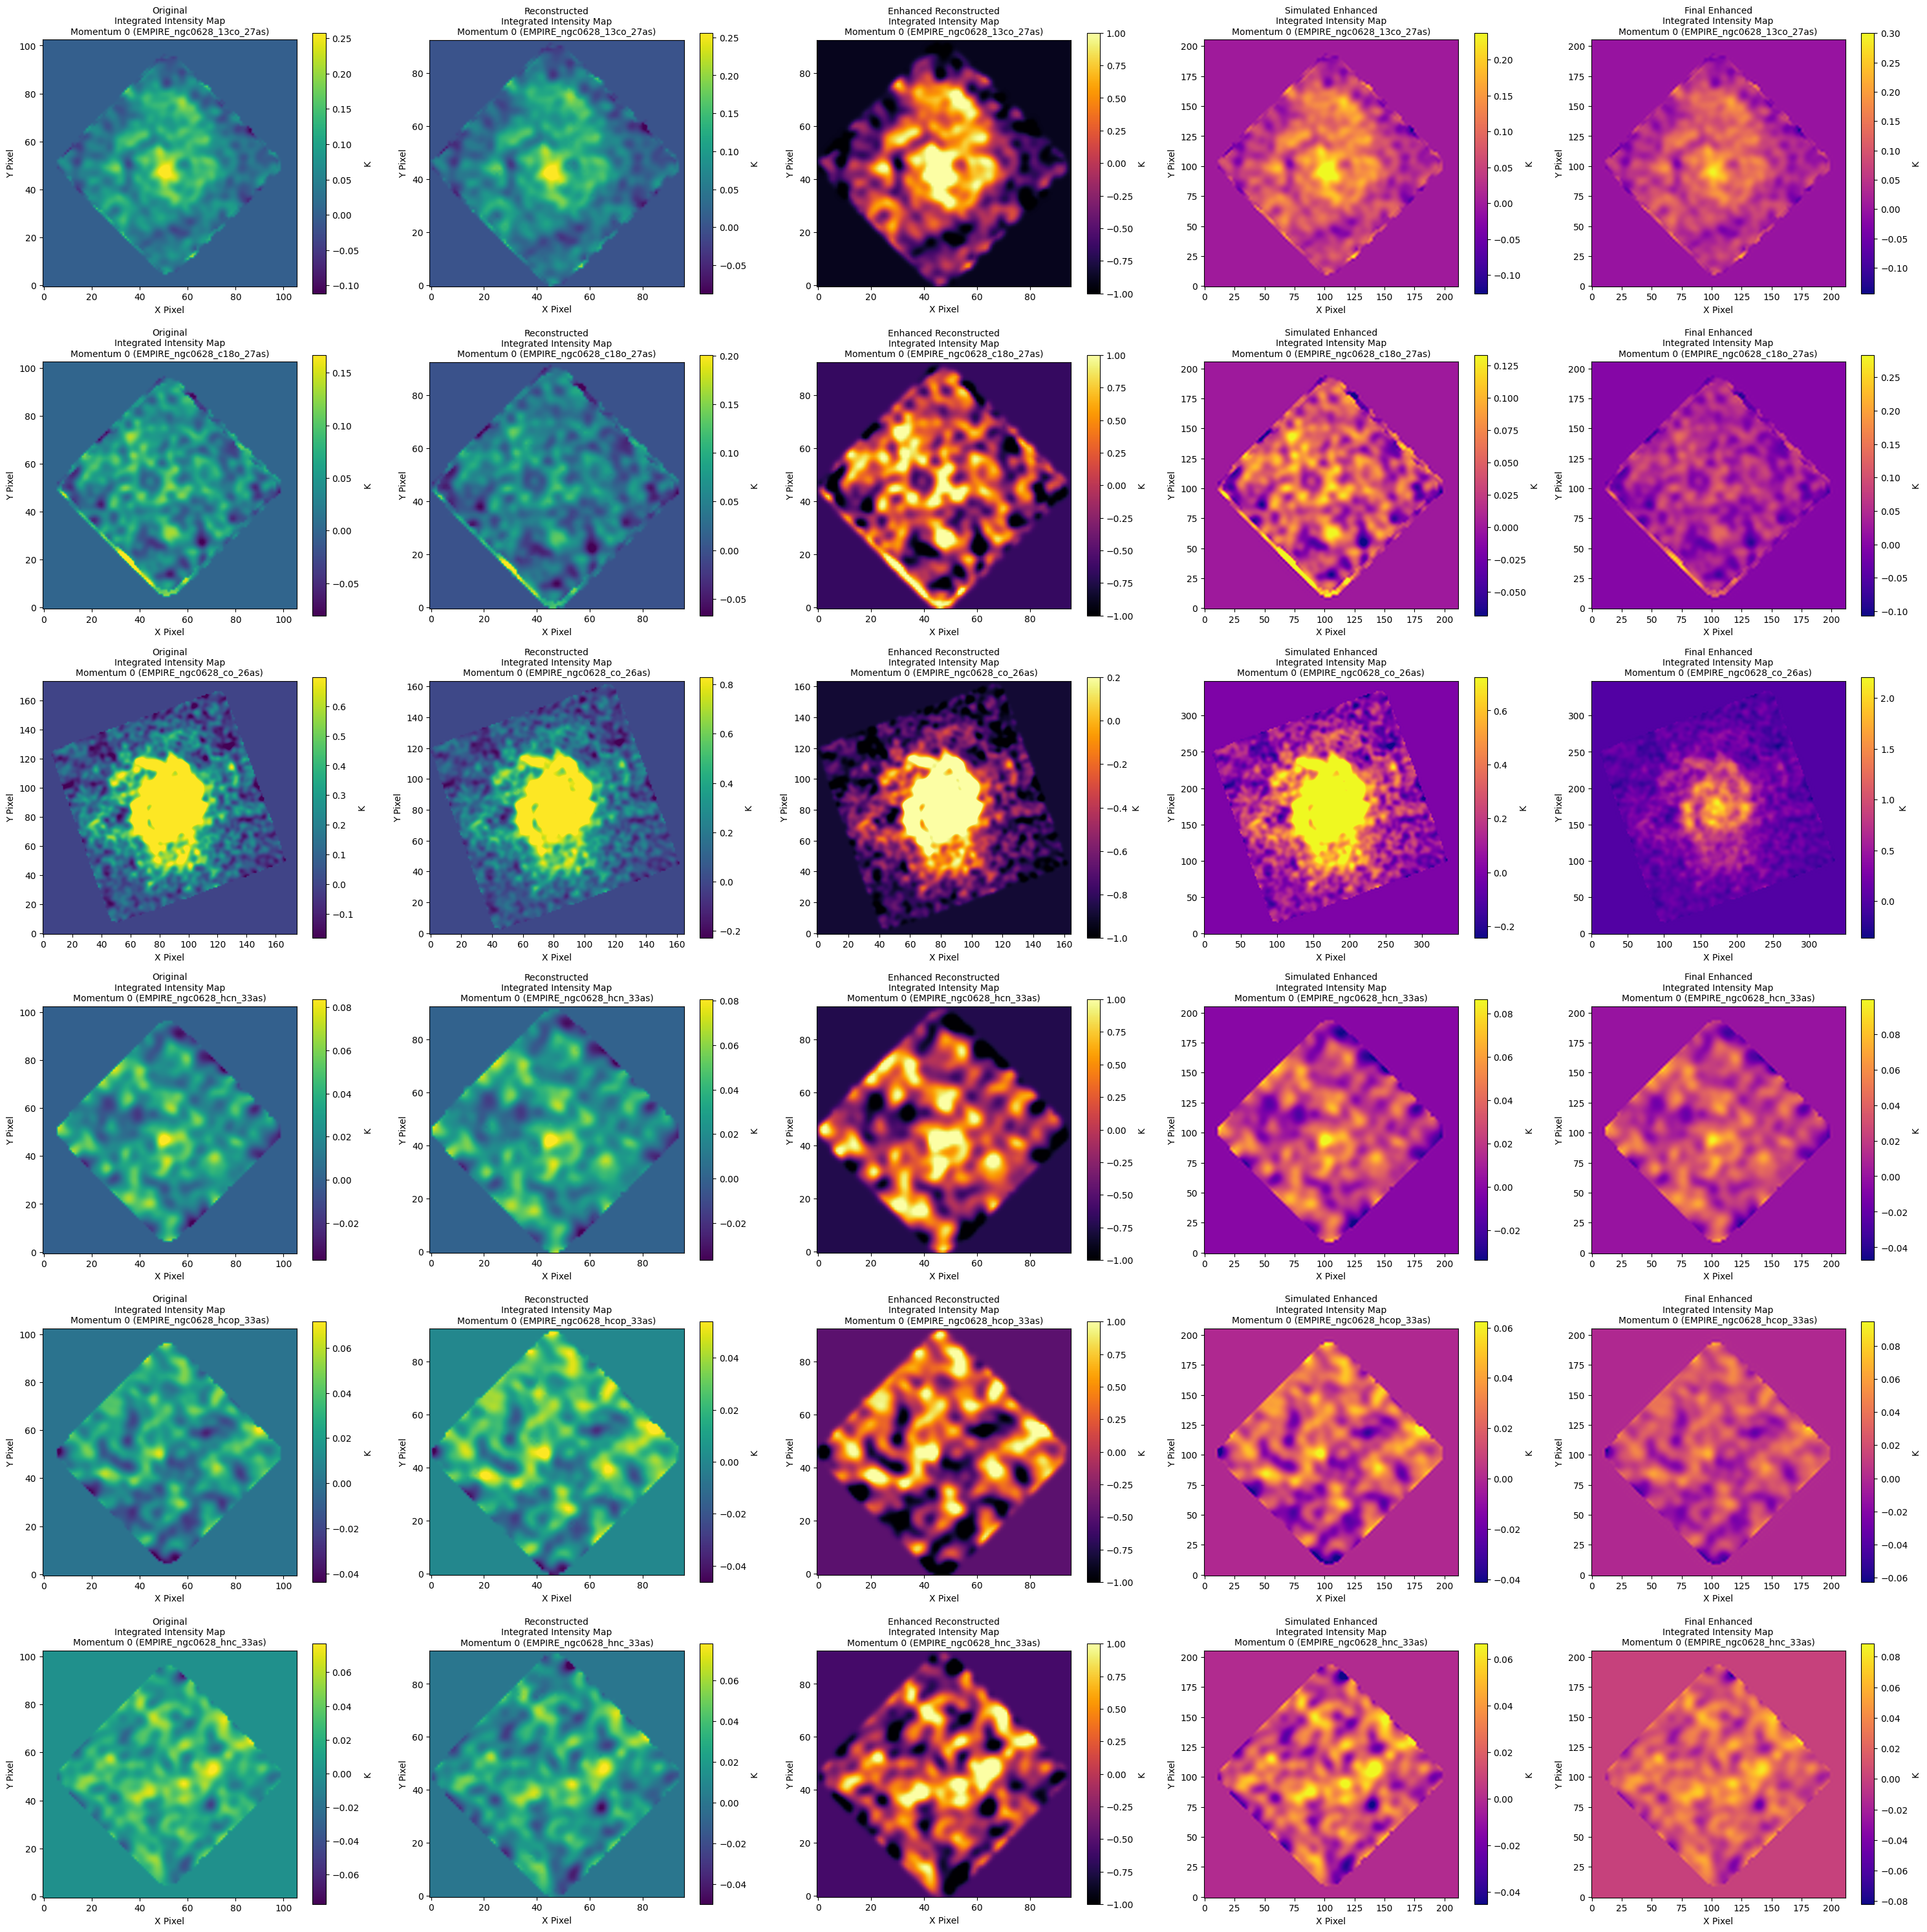

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ImageNormalize, ZScaleInterval
from scipy.ndimage import gaussian_filter, median_filter, binary_opening
from skimage import exposure
from scipy.signal import convolve
from scipy.ndimage import zoom

# Define the path to your FITS files
fits_files = [
    "fits_GL/EMPIRE_ngc0628_13co_27as.fits",
    "fits_GL/EMPIRE_ngc0628_c18o_27as.fits",
    "fits_GL/EMPIRE_ngc0628_co_26as.fits",
    "fits_GL/EMPIRE_ngc0628_hcn_33as.fits",
    "fits_GL/EMPIRE_ngc0628_hcop_33as.fits",
    "fits_GL/EMPIRE_ngc0628_hnc_33as.fits"
]

# Initialize lists to hold moment maps, corrupted, and reconstructed maps
moment_0_maps = []
corrupted_maps = []
reconstructed_maps = []
cleaned_reconstructed_maps = []
titles = []

# Function to corrupt image with NaN bad pixels
def create_bad_pixels(image, bad_pixel_frac=0.01, cross_frac=0.005):
    img = image.copy().astype(float)
    
    # Generate random bad pixels
    BP_mask = np.random.rand(img.shape[0], img.shape[1]) > (1 - bad_pixel_frac)
    
    # Generate cross-shaped regions of bad pixels
    cross_mask = np.random.rand(img.shape[0], img.shape[1]) > (1 - cross_frac)
    cross_generator = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
    BP_mask = (BP_mask + convolve(cross_mask, cross_generator, mode="same", method="direct")) != 0
    
    # Assign NaN to bad pixels
    img[BP_mask] = np.nan
    return img, BP_mask

# Dummy reconstruction function (to be replaced with actual method like astrofix)
def reconstruct_image(image, mask):
    fixed_image = np.copy(image)
    nans = np.isnan(image)
    
    # Simple reconstruction: replace NaNs with the mean of neighbors
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if nans[i, j]:
                fixed_image[i, j] = np.nanmean(image[i-1:i+2, j-1:j+2])
    return fixed_image

# Function to enhance sharpness using Gaussian filtering and contrast adjustment
def enhance_image(image, sigma=1, contrast_stretch=True):
    # Apply Gaussian filter to smooth out noise
    smoothed_image = gaussian_filter(image, sigma=sigma)

    if contrast_stretch:
        # Use contrast stretching for more natural enhancement
        finite_smoothed = smoothed_image[np.isfinite(smoothed_image)]
        
        if finite_smoothed.size > 0:  # Check if there are finite values
            p2, p98 = np.percentile(finite_smoothed, (2, 98))
            stretched_image = exposure.rescale_intensity(smoothed_image, in_range=(p2, p98))
            return stretched_image
        else:
            return smoothed_image  # Return unmodified if no valid data
    return smoothed_image

# Function to clean artifacts from reconstructed images
def clean_artifacts(image, threshold=1e3):
    # First, set values above a threshold to NaN
    clean_image = np.copy(image)
    clean_image[clean_image > threshold] = np.nan
    
    # Apply median filtering to remove noise
    median_filtered = median_filter(clean_image, size=3)
    
    # Apply binary opening to remove small artifacts
    binary_mask = median_filtered < threshold
    cleaned_image = binary_opening(binary_mask, structure=np.ones((3, 3)))
    
    # Replace cleaned areas with NaN in original image
    clean_image[~cleaned_image] = np.nan
    return clean_image

# Function to simulate super-resolution by resizing the image
def simulate_super_resolution(image, scale_factor=2):
    return zoom(image, scale_factor, order=3)  # cubic interpolation for smoother results

# Process each FITS file for moment maps
for file in fits_files:
    print(f"Processing {file}")
    
    # Open the FITS file
    with fits.open(file) as hdul:
        cube_data = hdul[0].data
        
        # Determine the base name for titles
        base_name = file.split('/')[-1].replace('.fits', '')
        
        # Check dimensions
        if cube_data.ndim == 3:
            # Calculate moment maps
            intensity = np.nansum(cube_data, axis=0)  # Moment-0
            moment_0_map = np.nan_to_num(intensity)
            moment_0_maps.append(moment_0_map)
            titles.append(f'Integrated Intensity Map\nMomentum 0 ({base_name})')

            # Corrupt the image
            corrupted_map, bad_pixel_mask = create_bad_pixels(moment_0_map)
            corrupted_maps.append(corrupted_map)
            
            # Reconstruct the corrupted image
            reconstructed_map = reconstruct_image(corrupted_map, bad_pixel_mask)
            reconstructed_maps.append(reconstructed_map)

        elif cube_data.ndim == 2:
            # For 2D data, just append directly and process similarly
            moment_0_maps.append(np.nan_to_num(cube_data))
            titles.append(f'Integrated Intensity Map\n({base_name})')

# Create plots to compare original, corrupted, reconstructed, enhanced images, and simulated super-resolution images
num_files = len(moment_0_maps)  # Number of files processed
fig, axes = plt.subplots(num_files, 5, figsize=(30, 5 * num_files))  # Increase columns for enhanced images

# Plot Moment-0 Maps with corrupted, reconstructed, enhanced, and simulated super-resolution versions
for i in range(num_files):
    # Plot Original Image
    norm_m0 = ImageNormalize(moment_0_maps[i], interval=ZScaleInterval())
    img_0 = axes[i, 0].imshow(moment_0_maps[i], cmap='viridis', origin='lower', norm=norm_m0, interpolation='bilinear')
    axes[i, 0].set_title(f'Original\n{titles[i]}', fontsize=10)
    axes[i, 0].set_xlabel('X Pixel')
    axes[i, 0].set_ylabel('Y Pixel')
    cbar_0 = plt.colorbar(img_0, ax=axes[i, 0])
    cbar_0.set_label('K')
    
    """
    # Plot Corrupted Image
    norm_corr = ImageNormalize(corrupted_maps[i], interval=ZScaleInterval())
    axes[i, 1].imshow(corrupted_maps[i], cmap='viridis', origin='lower', norm=norm_corr, interpolation='bilinear')
    axes[i, 1].set_title(f'Corrupted\n{titles[i]}', fontsize=10)
    axes[i, 1].set_xlabel('X Pixel')
    axes[i, 1].set_ylabel('Y Pixel')
    """

    # Plot Reconstructed Image with minimal cropping
    cropped_reconstructed_map = reconstructed_maps[i][5:-5, 5:-5]  # Crop a little from the margins
    norm_rec = ImageNormalize(cropped_reconstructed_map, interval=ZScaleInterval())
    img_1 = axes[i, 1].imshow(cropped_reconstructed_map, cmap='viridis', origin='lower', norm=norm_rec, interpolation='bilinear')
    axes[i, 1].set_title(f'Reconstructed\n{titles[i]}', fontsize=10)
    axes[i, 1].set_xlabel('X Pixel')
    axes[i, 1].set_ylabel('Y Pixel')
    cbar_1 = plt.colorbar(img_1, ax=axes[i, 1])
    cbar_1.set_label('K')
    
    # Clean artifacts in the reconstructed map
    cleaned_reconstructed_map = clean_artifacts(reconstructed_maps[i])
    cleaned_reconstructed_maps.append(cleaned_reconstructed_map)

    # Enhance and plot the cleaned reconstructed map with inferno filter
    if np.isfinite(cleaned_reconstructed_map).any():
        enhanced_reconstructed_map = enhance_image(cleaned_reconstructed_map, sigma=0.8, contrast_stretch=True)
        
        # Crop the enhanced image the same way as the reconstructed image
        cropped_enhanced_map = enhanced_reconstructed_map[5:-5, 5:-5]  
        
        norm_enhanced = ImageNormalize(cropped_enhanced_map, interval=ZScaleInterval())
        img_2 = axes[i, 2].imshow(cropped_enhanced_map, cmap='inferno', origin='lower', norm=norm_enhanced, interpolation='bilinear')
        axes[i, 2].set_title(f'Enhanced Reconstructed\n{titles[i]}', fontsize=10)
        axes[i, 2].set_xlabel('X Pixel')
        axes[i, 2].set_ylabel('Y Pixel')
        cbar_2 = plt.colorbar(img_2, ax=axes[i, 2])
        cbar_2.set_label('K')
    else:
        img_2 = axes[i, 2].imshow(np.zeros_like(cleaned_reconstructed_map), cmap='inferno', origin='lower')
        axes[i, 2].set_title(f'No Valid Data\n{titles[i]}', fontsize=10)
        axes[i, 2].set_xlabel('X Pixel')
        axes[i, 2].set_ylabel('Y Pixel')
        cbar_2 = plt.colorbar(img_2, ax=axes[i, 2])
        cbar_2.set_label('K')

    # Simulate super-resolution on the Moment-0 Map
    enhanced_moment_0_map = simulate_super_resolution(moment_0_maps[i])
    
    # Plot the Simulated Enhanced Integrated Intensity Map
    norm_sim_enhanced = ImageNormalize(enhanced_moment_0_map, interval=ZScaleInterval())
    img_3 = axes[i, 3].imshow(enhanced_moment_0_map, cmap='plasma', origin='lower', norm=norm_sim_enhanced, interpolation='bilinear')
    axes[i, 3].set_title(f'Simulated Enhanced\n{titles[i]}', fontsize=10)
    axes[i, 3].set_xlabel('X Pixel')
    axes[i, 3].set_ylabel('Y Pixel')
    cbar_3 = plt.colorbar(img_3, ax=axes[i, 3])
    cbar_3.set_label('K')

    # Enhance the reconstructed image again for the sixth plot
    enhanced_moment_0_np = simulate_super_resolution(moment_0_maps[i])
    img_4 = axes[i, 4].imshow(enhanced_moment_0_np, cmap='plasma', origin='lower')
    axes[i, 4].set_title(f'Final Enhanced\n{titles[i]}', fontsize=10)
    axes[i, 4].set_xlabel('X Pixel')
    axes[i, 4].set_ylabel('Y Pixel')
    cbar_4 = plt.colorbar(img_4, ax=axes[i, 4])
    cbar_4.set_label('K')

# Show the plot
plt.tight_layout()
plt.show()


The following code processes multiple FITS files containing astronomical data to compute and save moment-0 maps. 

1. **Library Imports**: The necessary libraries, including NumPy for numerical operations, Matplotlib for visualization, and Astropy for handling FITS files, are imported.

2. **FITS Files Definition**: A list of paths to the FITS files is defined, which contain data from various molecular emissions in the galaxy NGC 0628.

3. **Image Processing Loop**: The code iterates through each FITS file:
   - Each file is opened to access the data.
   - Moment-0 maps are computed by summing the data along the velocity axis for 3D cubes, or by using 2D data directly.
   - The computed moment-0 maps are normalized and visualized using a colormap.

4. **Image Saving**: The resulting images are saved to a specified path without axes or labels, ensuring a clean output suitable for analysis or presentation.

Overall, this code efficiently generates visual representations of astronomical data, enabling further scientific examination.


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ImageNormalize, ZScaleInterval

# Define the path to your FITS files
fits_files = [
    "fits_GL/EMPIRE_ngc0628_13co_27as.fits",
    "fits_GL/EMPIRE_ngc0628_c18o_27as.fits",
    "fits_GL/EMPIRE_ngc0628_co_26as.fits",
    "fits_GL/EMPIRE_ngc0628_hcn_33as.fits",
    "fits_GL/EMPIRE_ngc0628_hcop_33as.fits",
    "fits_GL/EMPIRE_ngc0628_hnc_33as.fits"
]

# Path to save images
save_path_template = "C:/Users/szoke/Data/Galaxies/{}.png"

# Process each FITS file for moment maps and save the images
for file in fits_files:
    print(f"Processing {file}")
    
    # Open the FITS file
    with fits.open(file) as hdul:
        cube_data = hdul[0].data
        
        # Determine the base name for file saving
        base_name = file.split('/')[-1].replace('.fits', '')
        
        if cube_data.ndim == 3:
            # Calculate moment maps (moment-0)
            intensity = np.nansum(cube_data, axis=0)  # Moment-0
            moment_0_map = np.nan_to_num(intensity)
        elif cube_data.ndim == 2:
            moment_0_map = np.nan_to_num(cube_data)
        
        # Save the image without color bar, axis labels, or ticks
        plt.figure()
        norm_m0 = ImageNormalize(moment_0_map, interval=ZScaleInterval())
        plt.imshow(moment_0_map, cmap='viridis', origin='lower', norm=norm_m0, interpolation='bilinear')
        
        # Remove axes, labels, and ticks
        plt.axis('off')
        
        # Save the figure
        save_path = save_path_template.format(base_name)
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        print(f"Saved image: {save_path}")


Processing fits_GL/EMPIRE_ngc0628_13co_27as.fits
Saved image: C:/Users/szoke/Data/Galaxies/EMPIRE_ngc0628_13co_27as.png
Processing fits_GL/EMPIRE_ngc0628_c18o_27as.fits
Saved image: C:/Users/szoke/Data/Galaxies/EMPIRE_ngc0628_c18o_27as.png
Processing fits_GL/EMPIRE_ngc0628_co_26as.fits
Saved image: C:/Users/szoke/Data/Galaxies/EMPIRE_ngc0628_co_26as.png
Processing fits_GL/EMPIRE_ngc0628_hcn_33as.fits
Saved image: C:/Users/szoke/Data/Galaxies/EMPIRE_ngc0628_hcn_33as.png
Processing fits_GL/EMPIRE_ngc0628_hcop_33as.fits
Saved image: C:/Users/szoke/Data/Galaxies/EMPIRE_ngc0628_hcop_33as.png
Processing fits_GL/EMPIRE_ngc0628_hnc_33as.fits
Saved image: C:/Users/szoke/Data/Galaxies/EMPIRE_ngc0628_hnc_33as.png


The following code performs image processing on various FITS files to generate moment-0 maps, which are essential for analyzing astronomical data. 

**Library Imports**: The code begins by importing the necessary libraries, including NumPy for numerical computations, Matplotlib for creating visualizations, and Astropy for reading and manipulating FITS files.

**FITS Files Definition**: A list of paths is defined, pointing to the FITS files that contain data on different molecular emissions from the galaxy NGC 0628.

**Image Processing Loop**: The code processes each FITS file in the list. For each file:
- The file is opened to extract the data.
- Moment-0 maps are computed by summing the data along the velocity axis for three-dimensional data cubes or using two-dimensional data directly.
- The resulting moment-0 maps are normalized and visualized with a colormap to enhance clarity.

**Image Saving**: Finally, the processed images are saved to a specified location without axes or labels, ensuring a clean presentation suitable for further analysis or inclusion in reports.

In summary, this code effectively transforms raw astronomical data into meaningful visual representations, facilitating deeper scientific insights.


11476 number of coefficients


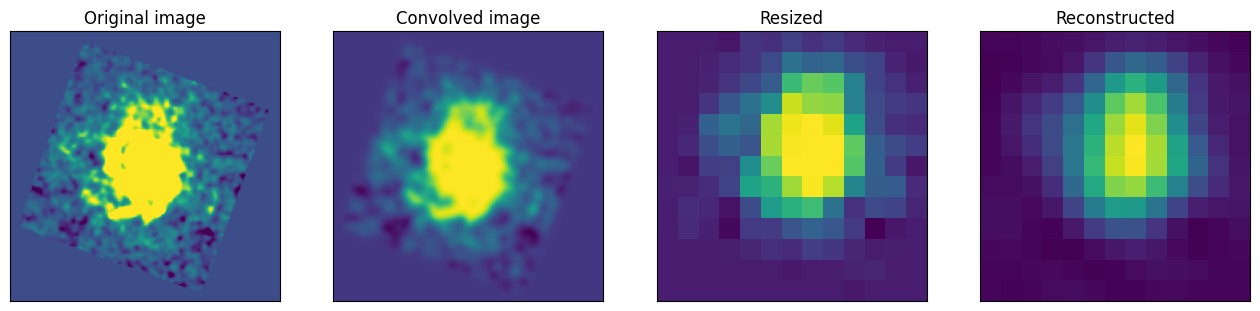

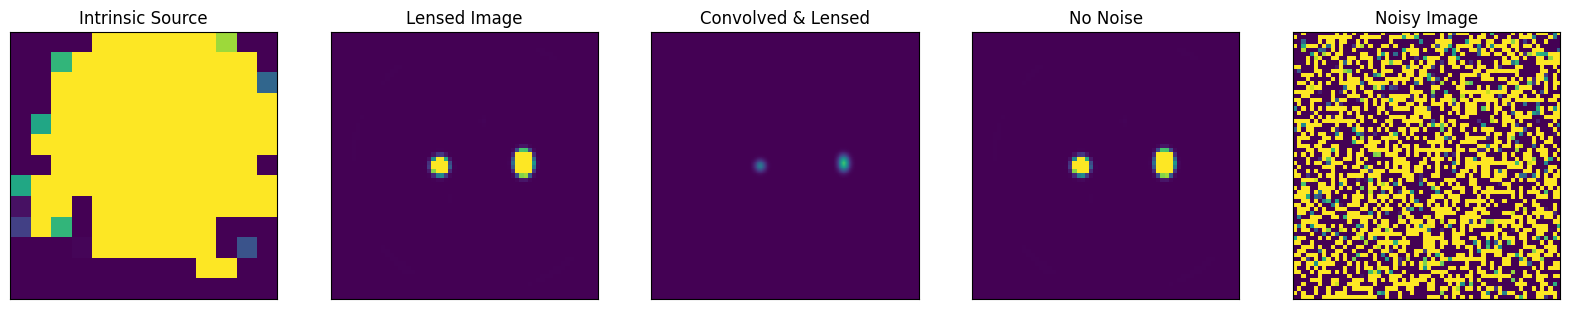

In [51]:
# Perform a basic comparison without a specific deconvolution step

# Standard Python imports
import numpy as np
import os
import scipy
import scipy.ndimage
import matplotlib.pyplot as plt
import imageio
from mpl_toolkits.axes_grid1 import make_axes_locatable
from lenstronomy.Util import util, image_util
from lenstronomy.LightModel.Profiles.shapelets import ShapeletSet
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Util import simulation_util as sim_util
from lenstronomy.Data.psf import PSF
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Util.util import image2array, array2image
from lenstronomy.Util.image_util import add_poisson, add_background
import imageio.v2 as imageio

# Make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

# Shapelet Image Decomposition
# Import NGC1300 jpg image and decompose it

# Find path to data
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
ngc_filename = os.path.join(module_path, 'C:/Users/szoke/Data/Galaxies/EMPIRE_ngc0628_co_26as.png')

# Read data
ngc_data = imageio.imread(ngc_filename, mode='F', pilmode=None)

# Subtract the median of an edge of the image
median = np.median(ngc_data[:200, :200])
ngc_data -= median

# Resize the image to square size (add zeros at the edges of the non-square bits of the image)
nx, ny = np.shape(ngc_data)
n_min = min(nx, ny)
n_max = max(nx, ny)
ngc_square = np.zeros((n_max, n_max))
x_start = int((n_max - nx) / 2.)
y_start = int((n_max - ny) / 2.)
ngc_square[x_start:x_start+nx, y_start:y_start+ny] = ngc_data

# Convolve the image with a Gaussian convolution kernel of a few pixels (optional)
sigma = 5
ngc_conv = scipy.ndimage.gaussian_filter(ngc_square, sigma, mode='nearest', truncate=6)

# Degrade the pixel resolution by a factor
factor = 25  # Lower resolution of image with a given factor
numPix_large = int(len(ngc_conv) / factor)
n_new = int((numPix_large - 1) * factor)
ngc_cut = ngc_conv[0:n_new, 0:n_new]
x, y = util.make_grid(numPix=numPix_large-1, deltapix=1)  # Make a coordinate grid
ngc_data_resized = image_util.re_size(ngc_cut, factor)  # Resize image to lower resolution

# Shapelet decomposition
# Turn the image into a single 1D array
image_1d = util.image2array(ngc_data_resized)  # Map 2D image in 1D data array

# Define the shapelet basis set we want the image to decompose in
n_max = 150  # Choice of number of shapelet basis functions, 150 is a high resolution number but takes long
beta = 10  # Shapelet scale parameter (in units of resized pixels)

# Import the ShapeletSet class
shapeletSet = ShapeletSet()

# Decompose image and return the shapelet coefficients
coeff_ngc = shapeletSet.decomposition(image_1d, x, y, n_max, beta, 1., center_x=0, center_y=0)
print(len(coeff_ngc), 'number of coefficients')  # Number of coefficients

# Reconstruct NGC1300 with the shapelet coefficients
image_reconstructed = shapeletSet.function(x, y, coeff_ngc, n_max, beta, center_x=0, center_y=0)
# Turn 1D array back into 2D image
image_reconstructed_2d = util.array2image(image_reconstructed)  # Map 1D data vector in 2D image

# Plot the original, convolved, resized, and reconstructed images
f, axes = plt.subplots(1, 4, figsize=(16, 4), sharex=False, sharey=False)
ax = axes[0]
ax.matshow(ngc_square, origin='lower')
ax.set_title("Original image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[1]
ax.matshow(ngc_conv, origin='lower')
ax.set_title("Convolved image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[2]
ax.matshow(ngc_data_resized, origin='lower')
ax.set_title("Resized")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[3]
ax.matshow(image_reconstructed_2d, origin='lower')
ax.set_title("Reconstructed")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

# Simulation Illustration with lenstronomy
# Define data specifics
background_rms = 10.0  # Background noise per pixel
exp_time = 100.0  # Exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 64  # Cutout pixel size
deltaPix = 0.05  # Pixel size in arcsec (area per pixel = deltaPix**2)
high_res_factor = 5
subgrid_res = high_res_factor  # Set the subgrid resolution to the high resolution image that we will show, so the same numerics will be applied.
fwhm = 0.1  # Full width half max of PSF
psf_type = 'GAUSSIAN'  # 'gaussian', 'pixel', 'NONE'

# Define lens model
lens_model_list = ['SPEP', 'SHEAR']
kwargs_spemd = {'theta_E': 0.5, 'gamma': 2.0, 'center_x': 0, 'center_y': 0, 'e1': 0, 'e2': 0}
kwargs_shear = {'gamma1': 0.0, 'gamma2': 0.0}
kwargs_lens = [kwargs_spemd, kwargs_shear]

# Define center of the source (effectively the center of the Shapelet basis)
source_x = 0.2
source_y = 0.0

# Define the source size (effectively the Shapelet scale parameter)
beta_model = 0.06
# Use the shapelet coefficients decomposed from NGC1300
coeff = coeff_ngc / deltaPix**2
kwargs_shapelet = {'n_max': n_max, 'beta': beta_model, 'amp': coeff, 'center_x': source_x, 'center_y': source_y}
source_model_list = ['SHAPELETS']
kwargs_source = [kwargs_shapelet]

# For this example, we do not include deflector light
lens_light_model_list = ['NONE']
kwargs_lens_light = [{}]

# Setup the different Data and PSF classes to perform and return the output at various stages of the computation
kwargs_data_real = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_real = ImageData(**kwargs_data_real)

kwargs_data_high_res = sim_util.data_configure_simple(numPix * high_res_factor, deltaPix / high_res_factor, exp_time, background_rms)
data_high_res = ImageData(**kwargs_data_high_res)

psf = PSF(psf_type=psf_type, fwhm=fwhm, truncation=5)
psf_high_res = psf
psf_no = PSF(psf_type='NONE')

# Compute the images
imageModel = ImageModel(data_class=data_real, psf_class=psf, kwargs_numerics={'supersampling_factor': subgrid_res, 'supersampling_convolution': True}, lens_model_class=LensModel(lens_model_list), source_model_class=LightModel(source_model_list))
image_no_noise_lensed = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=None)

poisson = add_poisson(image_no_noise_lensed, exp_time=exp_time)
bkg = add_background(image_no_noise_lensed, sigma_bkd=background_rms)
image_real_lensed = image_no_noise_lensed + poisson + bkg

imageModel_high_res = ImageModel(data_class=data_high_res, psf_class=psf_high_res, lens_model_class=LensModel(lens_model_list), source_model_class=LightModel(source_model_list))
image_high_res_conv_lensed = imageModel_high_res.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None)

# Display simulation results
f, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=False, sharey=False)
ax = axes[0]
ax.matshow(ngc_data_resized, origin='lower', vmin=0, vmax=2)
ax.set_title("Intrinsic Source")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[1]
ax.matshow(image_no_noise_lensed, origin='lower', vmin=0, vmax=2)
ax.set_title("Lensed Image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[2]
ax.matshow(image_high_res_conv_lensed, origin='lower', vmin=0, vmax=2)
ax.set_title("Convolved & Lensed")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[3]
ax.matshow(image_no_noise_lensed, origin='lower', vmin=0, vmax=2)
ax.set_title("No Noise")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[4]
ax.matshow(image_real_lensed, origin='lower', vmin=0, vmax=2)
ax.set_title("Noisy Image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()


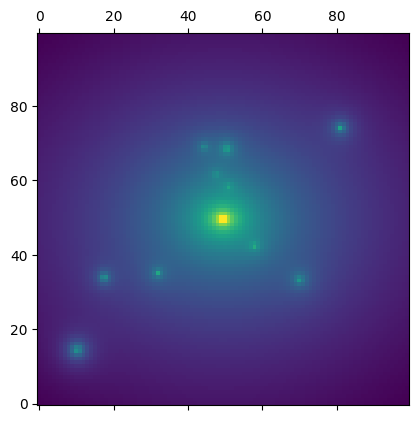

In [54]:
# define the lens model of the main deflector
main_halo_type = 'SIE'  # You have many other possibilities available. Check out the SinglePlane class!
kwargs_lens_main = {'theta_E': 1., 'e1': 0.1, 'e2': 0, 'center_x': 0, 'center_y': 0}
kwargs_shear = {'gamma1': 0.05, 'gamma2': 0}
lens_model_list = [main_halo_type, 'SHEAR']
kwargs_lens_list = [kwargs_lens_main, kwargs_shear]

subhalo_type = 'TNFW'  # We chose spherical NFW profiles, feel free to chose whatever you want.

# as an example, we render some sub-halos with a very simple distribution to be added on the main lens
num_subhalo = 10  # number of subhalos to be rendered
# the parameterization of the NFW profiles are:
# - Rs (radius of the scale parameter Rs in units of angles)
# - theta_Rs (radial deflection angle at Rs)
# - center_x, center_y, (position of the centre of the profile in angular units)

Rs_mean = 0.1
Rs_sigma = 0.1  # dex scatter
theta_Rs_mean = 0.05
theta_Rs_sigma = 0.1 # dex scatter
r_min, r_max = -2, 2

Rs_list = 10**(np.log10(Rs_mean) + np.random.normal(loc=0, scale=Rs_sigma, size=num_subhalo))
theta_Rs_list = 10**(np.log10(theta_Rs_mean) + np.random.normal(loc=0, scale=theta_Rs_sigma, size=num_subhalo))
center_x_list = np.random.uniform(low=r_min, high=r_max,size=num_subhalo)
center_y_list = np.random.uniform(low=r_min, high=r_max,size=num_subhalo)
for i in range(num_subhalo):
    lens_model_list.append(subhalo_type)
    kwargs_lens_list.append({'alpha_Rs': theta_Rs_list[i], 'Rs': Rs_list[i],
                             'center_x': center_x_list[i], 'center_y': center_y_list[i],
                            'r_trunc': 5*Rs_list[i]
                            })

# now we define a LensModel class of all the lens models combined
from lenstronomy.LensModel.lens_model import LensModel
lensModel = LensModel(lens_model_list)
# we set up a grid in coordinates and evaluate basic lensing quantities on it
x_grid, y_grid = util.make_grid(numPix=100, deltapix=0.05)
kappa = lensModel.kappa(x_grid, y_grid, kwargs_lens_list)
# we make a 2d array out of the 1d grid points
kappa = util.array2image(kappa)
# and plot the convergence of the lens model
plt.matshow(np.log10(kappa), origin='lower')
plt.show()

In [57]:
z_lens = 0.5
z_source = 2
from astropy.cosmology import default_cosmology
cosmo = default_cosmology.get()
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
# class that converts angular to physical units for a specific cosmology and redshift configuration
lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)

# here we turn an NFW halo defined as M200 crit and concentration into lensing quantities
M200 = 10**9
concentration = 6
Rs_angle_clump, theta_Rs_clump = lensCosmo.nfw_physical2angle(M=M200, c=concentration)
print(Rs_angle_clump, theta_Rs_clump)

# and here we do the oposite and turn the lensing quantities into physical units
rho0_clump, Rs_clump, c_clump, r200_clump, M200_clump = lensCosmo.nfw_angle2physical(Rs_angle_clump, theta_Rs_clump)
print(rho0_clump, Rs_clump, c_clump, r200_clump, M200_clump)

0.46485575154335124 0.0024104877548606738
2922417084656602.0 0.0029244057159433894 6.0000032204516405 0.017546443713567523 1000001610.2266853


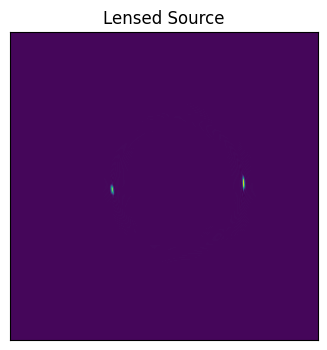

In [60]:
# Assuming lensModel and kwargs_lens_list are defined elsewhere
# Define parameters for high-resolution grid
numPix = 100  # Number of pixels (low resolution of data)
deltaPix = 0.05  # Pixel size (low resolution of data)
high_res_factor = 3  # Higher resolution factor (per axis)

# Create high-resolution grid
theta_x_high_res, theta_y_high_res = util.make_grid(numPix=numPix * high_res_factor, deltapix=deltaPix / high_res_factor)

# Ray-shoot the image plane coordinates (angles) to the source plane (angles)
beta_x_high_res, beta_y_high_res = lensModel.ray_shooting(theta_x_high_res, theta_y_high_res, kwargs=kwargs_lens_list)

# Define parameters for shapelet functions on the source plane
beta_source = 0.05  # Width of the shapelets (Gaussian width)
center_x = 0.2  # Center x position for shapelets on the source plane
center_y = 0.0  # Center y position for shapelets on the source plane

# Evaluate shapelet functions in the new coordinate system of the source plane
source_lensed = shapeletSet.function(beta_x_high_res, beta_y_high_res, coeff_ngc, n_max, beta=beta_source, center_x=center_x, center_y=center_y)

# Convert 1D vector back into a 2D array
source_lensed_2d = util.array2image(source_lensed)

# Plot the lensed source
f, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=False, sharey=False)
ax.imshow(source_lensed_2d, origin='lower')
ax.set_title("Lensed Source")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

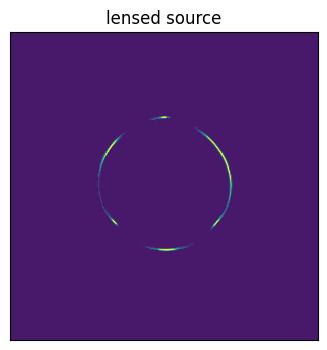

In [62]:
# here we perform the surface brightness computation with an interpolation function instead of the shapelets decomposition
# for high orders, this may be computationally more effective
kwargs_interp = {'image': ngc_data_resized, 'center_x': 0, 'center_y': 0, 'scale': 0.005, 'phi_G':0.2}
from lenstronomy.LightModel.Profiles.interpolation import Interpol
interp_light = Interpol()


source_lensed_interp = interp_light.function(beta_x_high_res, beta_y_high_res, **kwargs_interp)
# and turn the 1d vector back into a 2d array
source_lensed_interp = util.array2image(source_lensed_interp)  # map 1d data vector in 2d image

f, ax = plt.subplots(1, 1, figsize=(16, 4), sharex=False, sharey=False)
im = ax.matshow(source_lensed_interp, origin='lower')
ax.set_title("lensed source")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

**References**:

- Dataset: [Empire Survey](https://empiresurvey.yourwebsitespace.com/index.html)
- Lenstronomy Tutorials: [GitHub Repository](https://github.com/lenstronomy/lenstronomy-tutorias)
